# Murder Predication In Kerala (2026-2030 )

## STEP 1: IMPORT LIBRARIES

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


## STEP 2 : LOADING DATA

In [3]:
df= pd.read_csv('keralacrimerate.csv')
df.head()

,Crime Heads,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025 (Up to June)
0,Murder,305,305,292,323,306,337,334,352,335,174
1,Attempt to commit murder,622,583,672,729,610,600,700,991,1101,476
2,CH not amounting to murder,132,112,90,93,84,78,94,120,96,48
3,Rape,1656,2003,2005,2023,1880,2339,2518,2562,2091,1491
4,Kidnapping & abduction,241,293,297,386,307,364,403,306,231,111


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Crime Heads        21 non-null     object
 1   2016               21 non-null     int64 
 2   2017               21 non-null     int64 
 3   2018               21 non-null     int64 
 4   2019               21 non-null     int64 
 5   2020               21 non-null     int64 
 6   2021               21 non-null     int64 
 7   2022               21 non-null     int64 
 8   2023               21 non-null     int64 
 9   2024               21 non-null     int64 
 10  2025 (Up to June)  21 non-null     int64 
dtypes: int64(10), object(1)
memory usage: 1.9+ KB


## STEP 3: PREPROCESSING

In [5]:

# Keep only the "Murder" row
murder = df[df["Crime Heads"] == "Murder"].drop("Crime Heads", axis=1)


# Transpose to make years as rows
murder = murder.T
murder.columns = ["Murder"]

# Fix Year column
murder.index.name = "Year"
murder.reset_index(inplace=True)
murder["Year"] = murder["Year"].str.replace(" (Up to June)", "", regex=False).astype(int)


# Drop 2025 (partial data)
murder = murder[murder["Year"] != 2025]

# Final time series
murder.set_index("Year", inplace=True)
print(murder)


      Murder
Year        
2016     305
2017     305
2018     292
2019     323
2020     306
2021     337
2022     334
2023     352
2024     335


## STEP 4:  E D A

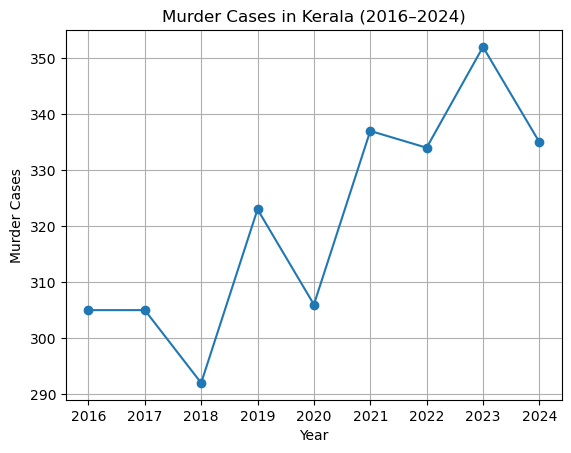

In [6]:


murder.plot(marker='o', legend=False)
plt.title("Murder Cases in Kerala (2016–2024)")
plt.xlabel("Year")
plt.ylabel("Murder Cases")
plt.grid(True)
plt.show()


## STEP 5: CHECK STATIONARITY 

In [17]:


result = adfuller(murder["Murder"])

print("ADF Statistic:", result[0])
print("p-value:", result[1])


ADF Statistic: -0.07479116091902213
p-value: 0.9518922605497828


### Key Note:

* The ADF statistic is -0.075 with a p-value of 0.952.
* Since the p-value is greater than 0.05, the data is non-stationary.
* We need to difference the data to make it stationary before modeling.

## STEP 6: DIFFERENCING THE SERIES TO ACHIEVE STATIONARITY

In [33]:
 # Select the series (Murder cases)

series = murder['Murder'] ## This line selects the 'Murder' column from the dataset and stores it as a series for analysis.
  
series_diff = series.diff().dropna()##  This line calculates the difference between consecutive values 
                                    ##  in the series and removes any missing values to help make the data stationary.

# Run ADF Test Again on Differenced Series
result_diff = adfuller(series_diff)
print("\nAfter Differencing:")
print("ADF Statistic:", result_diff[0])
print("p-value:", result_diff[1])


After Differencing:
ADF Statistic: -6.46673374916844
p-value: 1.3992357479862034e-08


### Key Notes

* After differencing, ADF statistic = -6.467
* p-value ≈ 0 (much less than 0.05)
* Result: Series is stationary
* Implication: Data is ready for time series modeling (trend removed)

## STEP 7: EVALUATING ACF AND PACF PLOTS FOR ARIMA MODELING

<Figure size 1200x600 with 0 Axes>

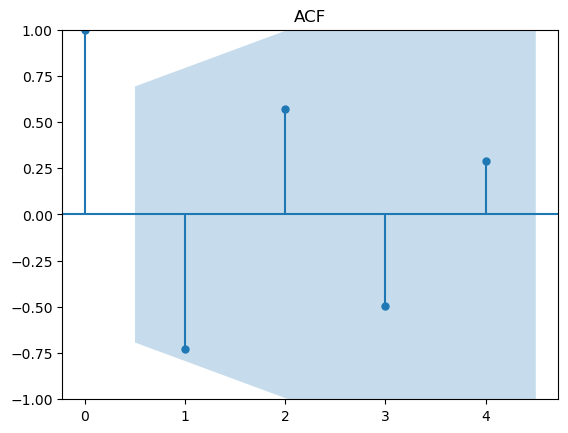

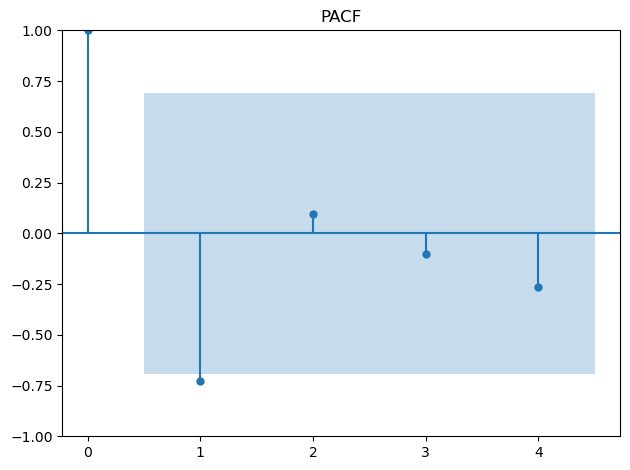

In [31]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Differenced series
series_diff = murder['Murder'].diff().dropna()

# PACF limit: max lags = 50% of series length
max_lags = max(1, len(series_diff)//2)

# Plot ACF and PACF
plt.figure(figsize=(12,6))

plot_acf(series_diff, lags=max_lags)
plt.title("ACF")

plot_pacf(series_diff, lags=max_lags, method='ywm')
plt.title("PACF")

plt.tight_layout()
plt.show()



### Top Plot (ACF):

* Shows how the current value is related to past values.
* Big spikes at lag 0 and 2 → these past points are strongly related to the current value.

### Bottom Plot (PACF):

* Shows the direct relationship with past values, ignoring other lags.
* Big spike at lag 1 → the first past value is very important.

### Key Note

* ACF → helps decide MA (moving average) part of ARIMA
* PACF → helps decide AR (autoregressive) part of ARIMA
* Series is now stable (stationary) → ready for ARIMA modeling.

## STEP 8: ARIMA MODEL & FORCAST

In [18]:


# 1. Build ARIMA model (p=1, d=1, q=1 as a start)
model = ARIMA(murder["Murder"], order=(1,1,1))

# 2. Fit the model
model_fit = model.fit()

# 3. Print summary (optional)
print(model_fit.summary())

# Forecast 1 year ahead (2026)
forecast = model_fit.forecast(steps=1)

# Option 1: Use .iloc to get the value
print("Predicted Murder Cases for 2026:", forecast.iloc[0])

# Option 2: Just print the whole forecast series
print(forecast)


                               SARIMAX Results                                
Dep. Variable:                 Murder   No. Observations:                    9
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -32.141
Date:                Sun, 24 Aug 2025   AIC                             70.281
Time:                        22:19:18   BIC                             70.520
Sample:                             0   HQIC                            68.674
                                  - 9                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0000      0.003   -307.448      0.000      -1.006      -0.994
ma.L1          0.9917      0.759      1.307      0.191      -0.495       2.479
sigma2       128.1887      0.006   2.15e+04      0.0

C:\Users\VISHNU MN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\VISHNU MN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\VISHNU MN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\VISHNU MN\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\VISHNU MN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction 

## STEP 9: VISALIZATION (Actual v/s forcast)

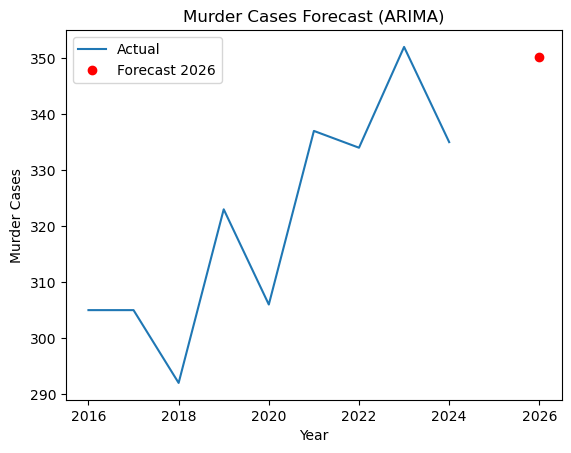

In [19]:

plt.plot(murder.index, murder["Murder"], label="Actual")
plt.plot([2026], [forecast.iloc[0]], "ro", label="Forecast 2026")
plt.xlabel("Year")
plt.ylabel("Murder Cases")
plt.title("Murder Cases Forecast (ARIMA)")
plt.legend()
plt.show()


In [20]:

#  Select the series (Murder cases)
series = murder['Murder']


series_diff = series.diff().dropna()

# Run ADF Test Again on Differenced Series
result_diff = adfuller(series_diff)
print("\nAfter Differencing:")
print("ADF Statistic:", result_diff[0])
print("p-value:", result_diff[1])



After Differencing:
ADF Statistic: -6.46673374916844
p-value: 1.3992357479862034e-08


## STEP 10:FORCAST 5 YEARS(2026-2030 MURDER)

In [64]:

forecast = model_fit.get_forecast(steps=5).predicted_mean
forecast.index = [2026, 2027, 2028, 2029, 2030,]
print(forecast)


2026    339.849635
2027    335.599122
2028    338.687667
2029    336.443441
2030    338.074160
Name: predicted_mean, dtype: float64


C:\Users\VISHNU MN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\VISHNU MN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


##  STEP 11: MODEL EVALUVATION

In [63]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# 1. Split data (2016–2022 → train, 2023–2024 → test)
train = murder[:7]   # first 7 years (2016–2022)
test = murder[7:]    # last 2 years (2023–2024)

# 2. Fit ARIMA on training data
model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()

# 3. Forecast for 2 years (2023–2024)
forecast = model_fit.forecast(steps=2)

# 4. Evaluate
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, forecast)

print("Actual (2023–2024):")
print(test.values)
print("Predicted (2023–2024):")
print(forecast.values)

print("\nEvaluation Metrics:")
print("MSE :", mse)
print("RMSE:", rmse)
print("MAE :", mae)


Actual (2023–2024):
[[352]
 [335]]
Predicted (2023–2024):
[339.84963497 335.59912175]

Evaluation Metrics:
MSE : 73.99515860627316
RMSE: 8.60204386214539
MAE : 6.374743387246411


C:\Users\VISHNU MN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\VISHNU MN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\VISHNU MN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\VISHNU MN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\VISHNU MN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available

# FINDINGS


# 1.Trend of Murder Cases (2016–2024):

#### * The number of murders showed fluctuations over the years.

#### * No strong upward or downward long-term trend was observed.

# 2.Stationarity Test:

#### * The data was not stationary (p-value > 0.05).

#### * This means the raw data had patterns that ARIMA needed to adjust (by differencing).

# 4. Future Predictions (2026–2030):

#### * Approximate range: 335–350 murder cases per year.

#### * No extreme increase or decrease is expected.

# 5. Practical Implication:

#### * Authorities can focus on maintaining consistent crime prevention measures.

#### * Emphasis should be on strengthening community safety programs rather than preparing for sudden spikes